In [9]:
##Testing Group lasso att. 1
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from group_lasso import LogisticGroupLasso
import collections
import matplotlib.pyplot as plt


In [10]:

# --- Step 1: Load data ---
df = pd.read_csv('gc_network_wide_with_depression_filtered.tsv', sep='\t')

# Basic sanity check on the data
assert df.shape[0] > 0, "No rows found in the dataset."
assert 'depression_binary' in df.columns, "Target column 'depression_binary' missing."

# Extract feature columns
feature_cols = [c for c in df.columns if c not in ['participant_id', 'depression_binary']]
assert feature_cols, "No connectivity features found."

X = df[feature_cols].astype(float).values
y = df['depression_binary'].values



In [11]:
# --- Step 2: Standardise predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check for NaNs after scaling
assert not np.isnan(X_scaled).any(), "NaN values encountered after scaling."


In [12]:

# --- Step 3: Create group mapping ---
group_names = []
groups = []
for col in feature_cols:
    group = col.split('-')[0]
    if group not in group_names:
        group_names.append(group)
    groups.append(group_names.index(group))
groups = np.array(groups)

# Ensure that we have at least two distinct groups
assert len(set(groups)) > 1, "Grouping failed: fewer than two groups detected."



In [24]:
# --- Step 4: Cross‑validate to select regularisation strength ---
regs = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
best_reg = None
best_auc = -np.inf

for reg in regs:
    aucs = []
    for train_idx, test_idx in cv.split(X_scaled, y):
        model = LogisticGroupLasso(
            groups=groups,
            group_reg=reg,
            l1_reg=0,
            n_iter=1000,
            tol=1e-3,
            scale_reg='group_size',
            fit_intercept=True,
            supress_warning=True
        )
        model.fit(X_scaled[train_idx], y[train_idx])
        y_pred = model.predict_proba(X_scaled[test_idx])[:, 1]
        aucs.append(roc_auc_score(y[test_idx], y_pred))
    mean_auc = np.mean(aucs)
    cv_results[reg] = mean_auc
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_reg = reg

# Check that cross‑validation produced a valid result
assert best_reg is not None, "Cross‑validation failed to select a regularisation parameter."
assert not np.isnan(best_auc), "AUC computation failed during cross‑validation."

print("Cross‑validated AUCs:", cv_results)
print("Selected group regularisation:", best_reg, " (AUC =", best_auc, ")")

# Optional sanity test: warn if the best AUC does not exceed random chance
if best_auc <= 0.6:
    print("Warning: the best AUC does not exceed 0.6; predictive performance may be poor.")


Cross‑validated AUCs: {0.01: 0.5206193588546529, 0.05: 0.5, 0.1: 0.5, 0.2: 0.5, 0.5: 0.5, 1.0: 0.5}
Selected group regularisation: 0.01  (AUC = 0.5206193588546529 )


In [25]:

# --- Step 5: Fit final model using the chosen parameter ---
final_model = LogisticGroupLasso(
    groups=groups,
    group_reg=best_reg,
    l1_reg=0,
    n_iter=2000,
    tol=1e-4,
    scale_reg='group_size',
    fit_intercept=True,
    supress_warning=True
)
final_model.fit(X_scaled, y)

# Check that at least one group was selected
assert getattr(final_model, 'chosen_groups_', None), "No groups were selected by the group lasso."



In [26]:
# --- Step 6: Compute group importance ---
coefs = final_model.coef_[0]  # For binary classification, shape (n_features,)
norms = collections.defaultdict(float)
for coef, gidx in zip(coefs, groups):
    norms[group_names[gidx]] += coef**2
for group in norms:
    norms[group] = np.sqrt(norms[group])

# Ensure at least one non‑zero norm
assert any(val > 0 for val in norms.values()), "All group coefficient norms are zero."

selected_groups = [group_names[idx] for idx in final_model.chosen_groups_]
print("Groups selected by the model:", selected_groups)

Groups selected by the model: ['ContA', 'ContB', 'ContC', 'DefaultA', 'DefaultB', 'DefaultC', 'DorsAttnA', 'DorsAttnB', 'LimbicB', 'SalVentAttnA', 'SalVentAttnB', 'SomMotA', 'SomMotB', 'TempPar', 'VisCent', 'VisPeri']


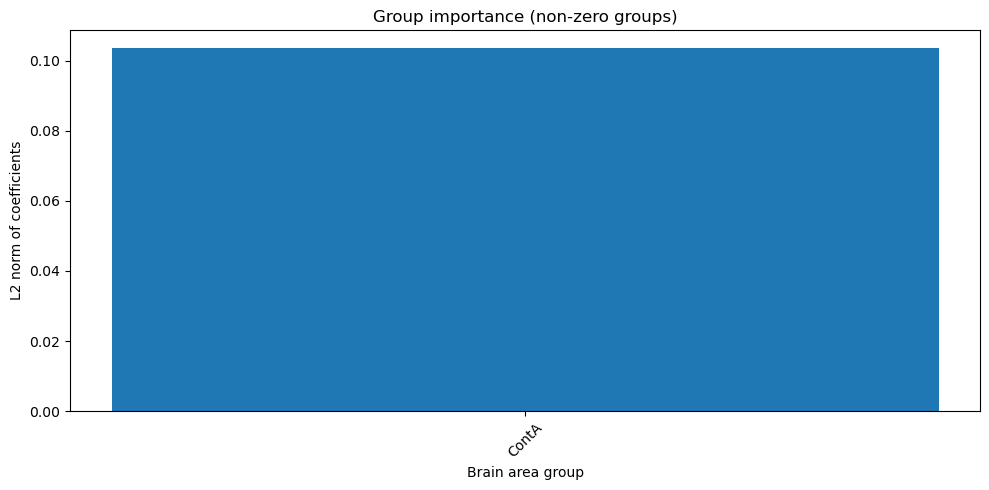